# Cotton Weed Detection Visuals



Quick utilities to preview annotated samples and export static assets for the README.

In [1]:
# Standard library imports
from pathlib import Path
from collections import Counter
import random

# Third-party imports
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches

# Project paths
PROJECT_ROOT = Path.cwd()
DATASET_ROOT = PROJECT_ROOT / "dataset"
IMAGE_SAVE_DIR = PROJECT_ROOT / "images"
IMAGE_SAVE_DIR.mkdir(exist_ok=True)

plt.style.use("seaborn-v0_8-colorblind")
random.seed(42)

with open(DATASET_ROOT / "dataset.yaml", "r", encoding="utf-8") as f:
    dataset_config = yaml.safe_load(f)

CLASS_NAMES = {int(k): v for k, v in dataset_config["names"].items()}
CLASS_COLORS = {
    0: "#e4572e",
    1: "#17bebb",
    2: "#ffc914",
}

TRAIN_IMAGES_DIR = DATASET_ROOT / "train" / "images"
TRAIN_LABELS_DIR = DATASET_ROOT / "train" / "labels"

In [5]:
def find_image_path(stem: str, search_dir: Path) -> Path:
    for ext in ("jpg", "jpeg", "png", "JPG", "JPEG", "PNG"):
        candidate = search_dir / f"{stem}.{ext}"
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"No image found for {stem}")


def load_yolo_labels(label_path: Path):
    boxes = []
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            boxes.append((int(cls), xc, yc, w, h))
    return boxes


def yolo_to_pixels(box, image_size):
    cls, xc, yc, w, h = box
    width, height = image_size
    box_w = w * width
    box_h = h * height
    x1 = (xc * width) - (box_w / 2)
    y1 = (yc * height) - (box_h / 2)
    return cls, x1, y1, box_w, box_h


def draw_boxes(ax, boxes, image_size):
    if not boxes:
        ax.text(
            0.5,
            0.5,
            "no boxes",
            transform=ax.transAxes,
            ha="center",
            va="center",
            fontsize=12,
            color="#333333",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="#999999"),
        )
        return

    for cls, xc, yc, w, h in boxes:
        cls_id = int(cls)
        name = CLASS_NAMES.get(cls_id, str(cls_id))
        color = CLASS_COLORS.get(cls_id, "#4c72b0")
        _, x1, y1, box_w, box_h = yolo_to_pixels((cls, xc, yc, w, h), image_size)
        rect = patches.Rectangle(
            (x1, y1),
            box_w,
            box_h,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            max(y1 - 6, 0),
            name,
            color="white",
            fontsize=9,
            bbox=dict(facecolor=color, alpha=0.7, pad=2, edgecolor="none"),
        )

In [6]:
all_label_paths = sorted(TRAIN_LABELS_DIR.glob("*.txt"))
if len(all_label_paths) < 3:
    raise RuntimeError("Need at least three annotated images for the preview.")

sample_size = min(3, len(all_label_paths))
sample_label_paths = random.sample(all_label_paths, sample_size)

sample_pairs = []
for label_path in sample_label_paths:
    image_path = find_image_path(label_path.stem, TRAIN_IMAGES_DIR)
    sample_pairs.append((image_path, label_path))

print("Selected samples:")
for image_path, label_path in sorted(sample_pairs):
    print(f"- {image_path.name} ({label_path.name})")

Selected samples:
- 20200526_iPhone8_CH_4.jpg (20200526_iPhone8_CH_4.txt)
- 20200625_NIKOND3300_YL_245.jpg (20200625_NIKOND3300_YL_245.txt)
- 20200819_NIKOND3300_YL_229.jpg (20200819_NIKOND3300_YL_229.txt)


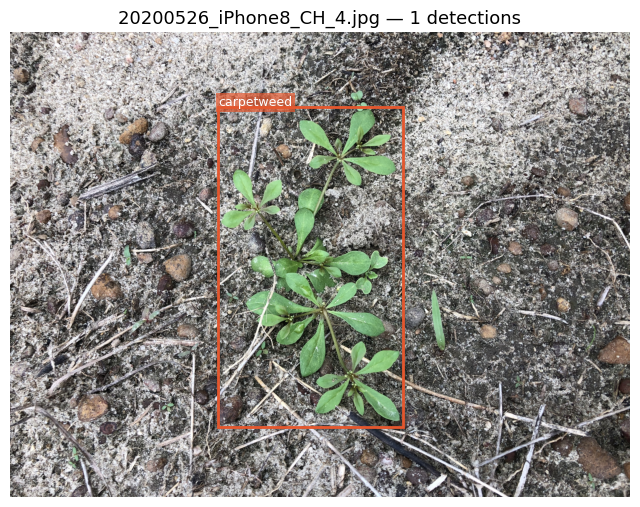

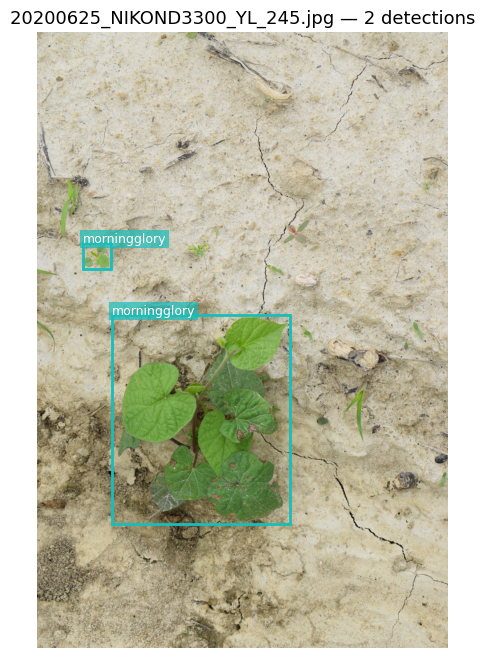

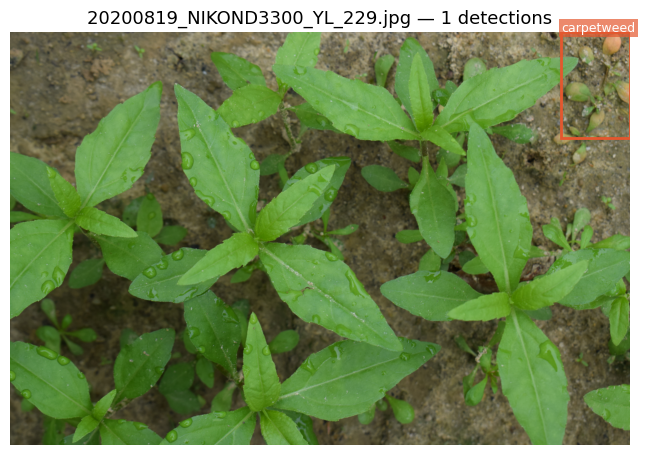

Saved detection visuals:
- images/sample_detection_1.png
- images/sample_detection_2.png
- images/sample_detection_3.png


In [7]:
saved_detection_paths = []

for idx, (image_path, label_path) in enumerate(sorted(sample_pairs), start=1):
    boxes = load_yolo_labels(label_path)
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    draw_boxes(ax, boxes, image.size)
    ax.set_title(f"{image_path.name} — {len(boxes)} detections", fontsize=13)
    ax.axis("off")

    output_path = IMAGE_SAVE_DIR / f"sample_detection_{idx}.png"
    fig.savefig(output_path, dpi=200, bbox_inches="tight")
    saved_detection_paths.append(output_path.relative_to(PROJECT_ROOT))

    plt.show()
    plt.close(fig)

print("Saved detection visuals:")
for path in saved_detection_paths:
    print(f"- {path}")

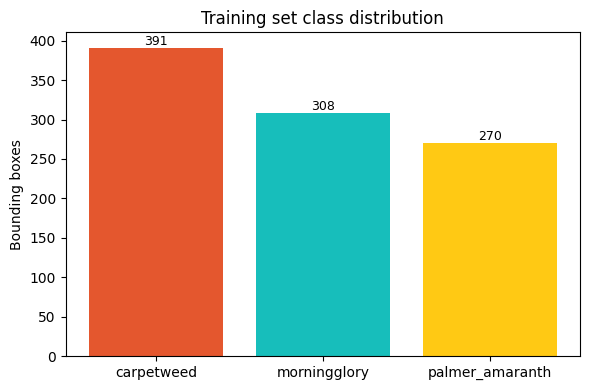

Saved class distribution chart to images/class_distribution.png


In [8]:
def compute_class_counts(label_paths):
    counts = Counter()
    for label_path in label_paths:
        boxes = load_yolo_labels(label_path)
        for cls, *_ in boxes:
            counts[cls] += 1
    return counts


class_counts = compute_class_counts(all_label_paths)
class_ids = sorted(CLASS_NAMES.keys())
counts = [class_counts.get(cid, 0) for cid in class_ids]
names = [CLASS_NAMES[cid] for cid in class_ids]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(names, counts, color=[CLASS_COLORS.get(cid, "#4c72b0") for cid in class_ids])
ax.set_ylabel("Bounding boxes")
ax.set_title("Training set class distribution")

for bar, count in zip(bars, counts):
    ax.text(
        bar.get_x() + (bar.get_width() / 2),
        bar.get_height(),
        str(count),
        ha="center",
        va="bottom",
        fontsize=9,
    )

fig.tight_layout()
distribution_path = IMAGE_SAVE_DIR / "class_distribution.png"
fig.savefig(distribution_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved class distribution chart to {distribution_path.relative_to(PROJECT_ROOT)}")